In [33]:
conda install -c conda-forge bayesian-optimization

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\leila\anaconda3

  added / updated specs:
    - bayesian-optimization


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bayesian-optimization-1.1.0|             py_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          12 KB

The following NEW packages will be INSTALLED:

  bayesian-optimiza~ conda-forge/noarch::bayesian-optimization-1.1.0-py_0




bayesian-optimizatio | 12 KB     |            |   0% 
bayesian-optimizatio | 12 KB     | ########## | 100% 
bayesian-optimizatio | 12 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import csv
from timeit import default_timer as timer
from pickle import dump

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

from hyperopt import STATUS_OK
from hyperopt import Trials, hp, tpe, fmin, space_eval
from hyperopt.pyll import scope
import warnings

warnings.filterwarnings("ignore")
import shap

Lecture des donnees

In [12]:
df = pd.read_csv('C:/Users/leila/df_all.csv.gz', compression='gzip')


In [3]:
df_class = df[df['TARGET'].notnull()].copy()
df_class.shape

(307507, 798)

In [6]:
def missing_values(data, plot=False):
    '''Missing Value'''
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

In [7]:
missing_values(df_class, plot=False)

Number of Variables include Missing Values: 616 

                            Feature  Num_Missing  Missing_Ratio DataTypes
0     REFUSED_AMT_DOWN_PAYMENT_MEAN       262339       0.853116   float64
1    REFUSED_RATE_DOWN_PAYMENT_MEAN       262339       0.853116   float64
2     REFUSED_RATE_DOWN_PAYMENT_MAX       262339       0.853116   float64
3     REFUSED_RATE_DOWN_PAYMENT_MIN       262339       0.853116   float64
4      REFUSED_AMT_DOWN_PAYMENT_MIN       262339       0.853116   float64
..                              ...          ...            ...       ...
611                     AMT_ANNUITY           12       0.000039   float64
612             ANNUITY_INCOME_PERC           12       0.000039   float64
613                 CNT_FAM_MEMBERS            2       0.000007   float64
614               INCOME_PER_PERSON            2       0.000007   float64
615          DAYS_LAST_PHONE_CHANGE            1       0.000003   float64

[616 rows x 4 columns] 



In [8]:
df_missing = (df_class.isnull().sum() / len(df_class)).sort_values(ascending = False)
df_missing = df_missing.index[df_missing > 0.75]

print('There are %d columns with more than 75%% missing values' % len(df_missing))

There are 42 columns with more than 75% missing values


In [9]:
df_class = pd.get_dummies(df_class.drop(columns =df_missing))
df_class.shape

(307507, 756)

importance des features avec 10% du df_class

In [10]:
df_class = df_class.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [13]:
df = pd.get_dummies(df.drop(columns =df_missing))
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [14]:
df_red = df_class.sample(30000, random_state= 23).copy()
df_red.shape

(30000, 756)

In [15]:
# Collect features
feats = [
    f for f in df_red.columns if f not in
    ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
]

# Create dF with all features without TARGET
train_df = df_red[df_red['TARGET'].notnull()][feats]
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Create dF TARGET
train_target = df_red[df_red['TARGET'].notnull()]['TARGET']

In [16]:
feature_importances = np.zeros(train_df.shape[1])


LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}
# Create the model with several hyperparameters
model = LGBMClassifier(**LIGHTGBM_PARAMS)

In [17]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = \
    train_test_split(train_df, train_target, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100,
              eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.744582	valid_0's binary_logloss: 0.261982
[400]	valid_0's auc: 0.753369	valid_0's binary_logloss: 0.254227
[600]	valid_0's auc: 0.755174	valid_0's binary_logloss: 0.251878
Early stopping, best iteration is:
[672]	valid_0's auc: 0.75621	valid_0's binary_logloss: 0.251299
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.74825	valid_0's binary_logloss: 0.26348
[400]	valid_0's auc: 0.754003	valid_0's binary_logloss: 0.255983
[600]	valid_0's auc: 0.756337	valid_0's binary_logloss: 0.253303
[800]	valid_0's auc: 0.759361	valid_0's binary_logloss: 0.251836
[1000]	valid_0's auc: 0.760627	valid_0's binary_logloss: 0.251414
[1200]	valid_0's auc: 0.760921	valid_0's binary_logloss: 0.251496
Early stopping, best iteration is:
[1100]	valid_0's auc: 0.760967	valid_0's binary_logloss: 0.251291


In [18]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train_df.columns),
                                    'importance': feature_importances})\
.sort_values('importance', ascending = False)

In [19]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 219 features with 0.0 importance


,feature,importance
93,FLAG_DOCUMENT_14,0.0
92,FLAG_DOCUMENT_13,0.0
91,FLAG_DOCUMENT_12,0.0
90,FLAG_DOCUMENT_11,0.0
175,ORGANIZATION_TYPE_Electricity,0.0


In [20]:
train_df = train_df.drop(columns = zero_features)

In [21]:
df = df.drop(columns = zero_features)
df.to_csv('df.csv')

In [22]:
train_df.to_csv('train_df.csv')
train_target.to_csv('train_target.csv')

In [23]:
train_df.shape

(30000, 534)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_df,
                                                    train_target,
                                                    test_size=0.3, random_state=42)
train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)

In [25]:
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':100,
              'learning_rate':0.03,
              'metric':'auc',
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, train_data, nfold=5,
                       seed=6, stratified=True,
                       metrics=['auc'], return_cvbooster=True)
    return max(cv_result['auc-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)

In [26]:
lgbBO.maximize(init_points=2, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.53905080314

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081131 -> initscore=-2.427079
[LightGBM] [Info] Start training from score -2.427079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] feature_fraction is set=0.8134184006256638, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8134184006256638
[LightGBM] [Info] Number of positive: 1363, number of negative: 15437
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77964
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 534
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  2        |  0.7537   |  0.8134   |  4.818    |  1.15     |  8.167    |  28.8     |  0.05724  |  43.44    |
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315


[LightGBM] [Warning] lambda_l2 is set=2.1674963923113335, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1674963923113335
[LightGBM] [Warning] lambda_l1 is set=2.9699162251902895, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.9699162251902895
[LightGBM] [Warning] feature_fraction is set=0.894127419305972, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.894127419305972
[LightGBM] [Info] Number of positive: 1363, number of negative: 15437
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77964
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 534
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  3        |  0.7553   |  0.8941   |  2.97     |  2.167    |  5.936    |  34.47    |  0.002813 |  24.2     |
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lam

[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.1076739957469837, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.1076739957469837
[LightGBM] [Warning] lambda_l1 is set=3.0317053220486354, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.0317053220486354
[LightGBM] [Warning] feature_fraction is set=0.5444570573181484, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5444570573181484
[LightGBM] [Info] Number of positive: 1363, number of negative: 15437
[LightGBM] [Warning] Auto-choosing col-wise mult

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77964
[LightGBM] [Info] Number of data points in the train set: 16800, number of used features: 534
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [27]:
lgbBO.max

{'target': 0.7573006706847757,
 'params': {'feature_fraction': 0.5444570573181484,
  'lambda_l1': 3.0317053220486354,
  'lambda_l2': 1.1076739957469837,
  'max_depth': 5.130780759274395,
  'min_child_weight': 36.14590362722896,
  'min_split_gain': 0.06471036899055556,
  'num_leaves': 37.86477833978305}}

In [28]:
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df = pd.DataFrame()

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            colsample_bytree=0.9497036,
            feature_fraction=0.54,
            lambda_l1=3.04,
            lambda_l2=1.11,
            learning_rate=0.03,
            max_depth=5,
            min_child_weight=36.14590362722896,
            min_split_gain=0.06471036899055556,
            num_leaves=38,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=-1,
            subsample=0.8715623,
            verbose=-1, )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train[val_idx] = clf.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test += clf.predict_proba(X_test[feats],
                                  num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_train, pred_train))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.54, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.54
[LightGBM] [Warning] lambda_l1 is set=3.04, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.04
[LightGBM] [Warning] lambda_l2 is set=1.11, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.11
Training until validation scores don't improve for 30 rounds
[100]	training's auc: 0.836921	training's binary_logloss: 0.228924	valid_1's auc: 0.739984	valid_1's binary_logloss: 0.253016
[200]	training's auc: 0.871335	training's binary_logloss: 0.211175	valid_1's auc: 0.746068	valid_1's binary_logloss: 0.250114
[300]	training's auc: 0.893395	training's binary_logloss: 0.199597	valid_1's auc: 0.749123	valid_1's binary_logloss: 0.249214
Early stopping, best iteration is:
[294]	training's auc: 0.892125	training's binary_logloss

In [29]:
roc_auc_score(y_test, pred_test)

0.7677067138542302

In [30]:
roc_auc_score(y_train, pred_train)

0.7568164958170807

In [31]:
def plt_confusion_matrix(y_true, y_pred):
    '''fonction qui trace la matrice de confusion'''
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="YlGnBu")
    plt.ylabel('True classes', fontsize=14)
    plt.xlabel('Predicted classes', fontsize=14)
    plt.title('Matrice de confusion', fontsize=20)
    print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     19296
         1.0       0.86      0.06      0.11      1704

    accuracy                           0.92     21000
   macro avg       0.89      0.53      0.53     21000
weighted avg       0.92      0.92      0.89     21000



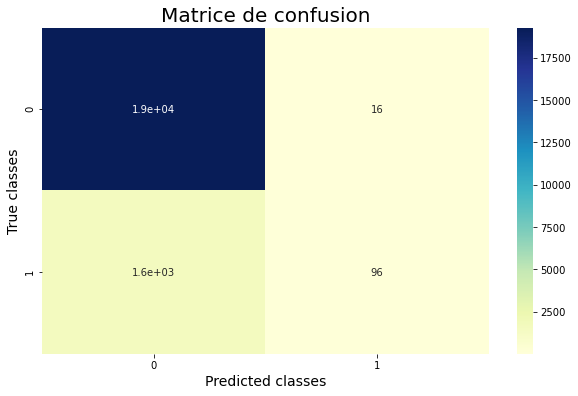

In [32]:
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['predicted_class'] = clf.predict(X_train[feats])
pred_train_df['TARGET'] = y_train
plt_confusion_matrix(pred_train_df['TARGET'], pred_train_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8278
         1.0       0.29      0.01      0.01       722

    accuracy                           0.92      9000
   macro avg       0.60      0.50      0.48      9000
weighted avg       0.87      0.92      0.88      9000



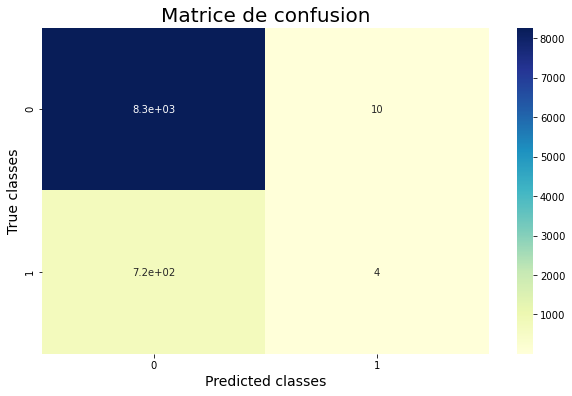

In [45]:
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['TARGET'] = y_test
pred_test_df['predicted_class'] = clf.predict(X_test[feats])
plt_confusion_matrix(pred_test_df['TARGET'], pred_test_df['predicted_class'])

In [33]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby(
        "feature").mean().sort_values(
            by="importance", ascending=False)[:20].index

    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6, 6))
    scores = []
    for n_fold, (_, val_idx) in enumerate(folds_idx_):
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

    plt.plot(
        [0, 1], [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(
        fpr,
        tpr,
        color='b',
        label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
        lw=2,
        alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()


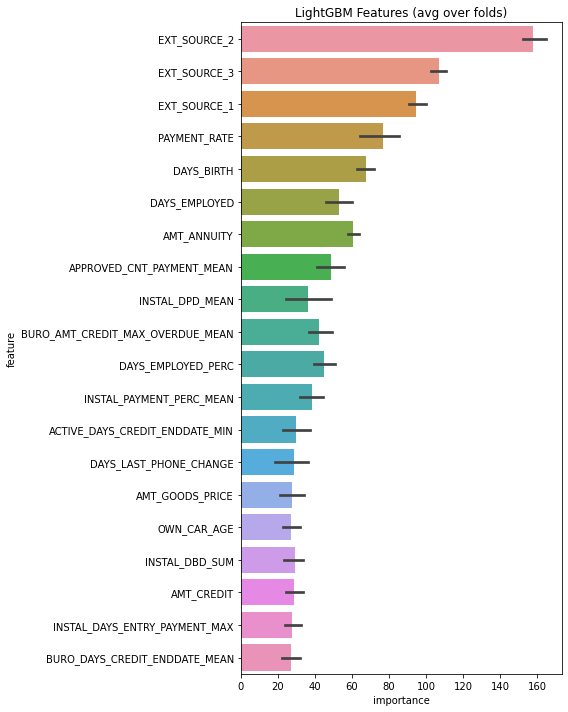

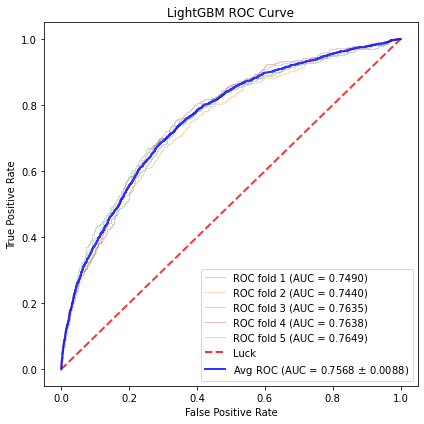

In [34]:
folds_idx = [(trn_idx, val_idx)
                 for trn_idx, val_idx in folds.split(X_train, y_train)]
display_importances(feature_importance_df_=feature_importance_df)
display_roc_curve(y_=y_train, oof_preds_=pred_train, folds_idx_=folds_idx)

In [35]:
model = clf
X = X_test[feats]
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

100%|===================| 8958/9000 [01:07<00:00]        

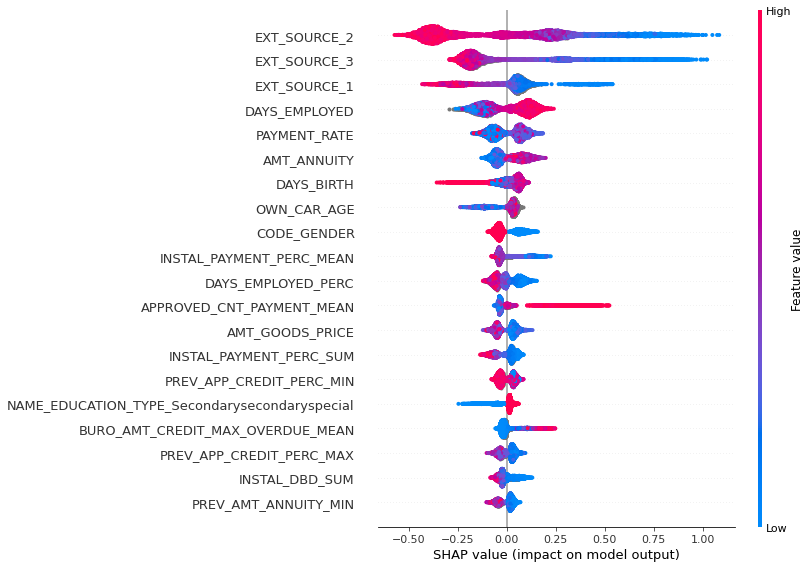

In [36]:
shap.summary_plot(shap_values, X[feats])

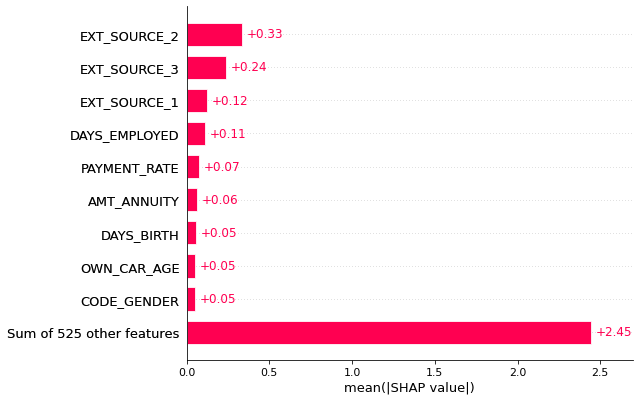

In [37]:
shap.plots.bar(shap_values)

Oversampling

In [51]:
from imblearn.over_sampling import RandomOverSampler

rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)

pred_train_ro = np.zeros(X_ro.shape[0])
pred_test_ro = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_ro = pd.DataFrame()

feats = [f for f in X_ro.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_ro = LGBMClassifier(
            ccolsample_bytree=0.9497036,
            feature_fraction=0.6,
            lambda_l1=3.04,
            lambda_l2=1.11,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=36.14590362722896,
            min_split_gain=0.06471036899055556,
            num_leaves=38,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=-1,
            subsample=0.8715623,
            verbose=-1, )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ro, y_ro)):
    trn_x, trn_y = X_ro[feats].iloc[trn_idx], y_ro.iloc[trn_idx]
    val_x, val_y = X_ro[feats].iloc[val_idx], y_ro.iloc[val_idx]

    clf_ro.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train_ro[val_idx] = clf_ro.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test_ro += clf_ro.predict_proba(X_test[feats],
                                         num_iteration=clf_ro.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_ro = pd.DataFrame()
    fold_importance_df_ro["feature"] = feats
    fold_importance_df_ro["importance"] = clf_ro.feature_importances_
    fold_importance_df_ro["fold"] = n_fold + 1
    feature_importance_df_ro = pd.concat([feature_importance_df_ro, fold_importance_df_ro], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ro[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_ro, pred_train_ro))

[LightGBM] [Warning] Unknown parameter: ccolsample_bytree
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=3.04, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.04
[LightGBM] [Warning] lambda_l2 is set=1.11, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.11
Training until validation scores don't improve for 30 rounds
[100]	training's auc: 0.914923	training's binary_logloss: 0.460548	valid_1's auc: 0.893825	valid_1's binary_logloss: 0.481535
[200]	training's auc: 0.952163	training's binary_logloss: 0.386243	valid_1's auc: 0.931148	valid_1's binary_logloss: 0.415201
[300]	training's auc: 0.972	training's binary_logloss: 0.338126	valid_1's auc: 0.952964	valid_1's binary_logloss: 0.372055
[400]	training's auc: 0.982951	training's bi

[2500]	training's auc: 0.999987	training's binary_logloss: 0.0572812	valid_1's auc: 0.99905	valid_1's binary_logloss: 0.103027
[2600]	training's auc: 0.99999	training's binary_logloss: 0.0542662	valid_1's auc: 0.999108	valid_1's binary_logloss: 0.0998681
[2700]	training's auc: 0.999993	training's binary_logloss: 0.0516869	valid_1's auc: 0.999162	valid_1's binary_logloss: 0.0971884
[2800]	training's auc: 0.999994	training's binary_logloss: 0.0493927	valid_1's auc: 0.999204	valid_1's binary_logloss: 0.0947904
Early stopping, best iteration is:
[2829]	training's auc: 0.999994	training's binary_logloss: 0.0487858	valid_1's auc: 0.999214	valid_1's binary_logloss: 0.0941481

 Fold  2 AUC : 0.933597
[LightGBM] [Warning] Unknown parameter: ccolsample_bytree
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[Li

[2200]	training's auc: 0.999981	training's binary_logloss: 0.0676103	valid_1's auc: 0.99929	valid_1's binary_logloss: 0.108586
[2300]	training's auc: 0.999985	training's binary_logloss: 0.06369	valid_1's auc: 0.999377	valid_1's binary_logloss: 0.104459
[2400]	training's auc: 0.999988	training's binary_logloss: 0.0602672	valid_1's auc: 0.999407	valid_1's binary_logloss: 0.100778
[2500]	training's auc: 0.99999	training's binary_logloss: 0.0568032	valid_1's auc: 0.999478	valid_1's binary_logloss: 0.0968941
[2600]	training's auc: 0.999992	training's binary_logloss: 0.0539981	valid_1's auc: 0.999538	valid_1's binary_logloss: 0.0938386
[2700]	training's auc: 0.999994	training's binary_logloss: 0.0515893	valid_1's auc: 0.999575	valid_1's binary_logloss: 0.0911146
[2800]	training's auc: 0.999995	training's binary_logloss: 0.0494228	valid_1's auc: 0.999601	valid_1's binary_logloss: 0.0887564
Early stopping, best iteration is:
[2845]	training's auc: 0.999996	training's binary_logloss: 0.0485118	

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19296
         1.0       0.99      1.00      1.00     19296

    accuracy                           1.00     38592
   macro avg       1.00      1.00      1.00     38592
weighted avg       1.00      1.00      1.00     38592



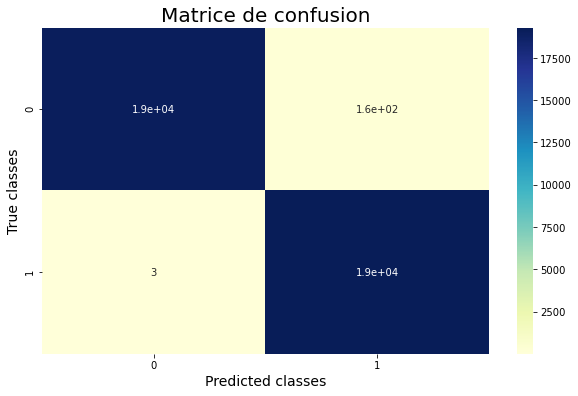

In [52]:
pred_train_ro_df = pd.DataFrame(index=X_ro.index)
pred_train_ro_df['predicted_class'] = clf_ro.predict(X_ro[feats])
pred_train_ro_df['TARGET'] = y_ro
plt_confusion_matrix(pred_train_ro_df['TARGET'], pred_train_ro_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      8278
         1.0       0.31      0.21      0.25       722

    accuracy                           0.90      9000
   macro avg       0.62      0.58      0.60      9000
weighted avg       0.88      0.90      0.89      9000



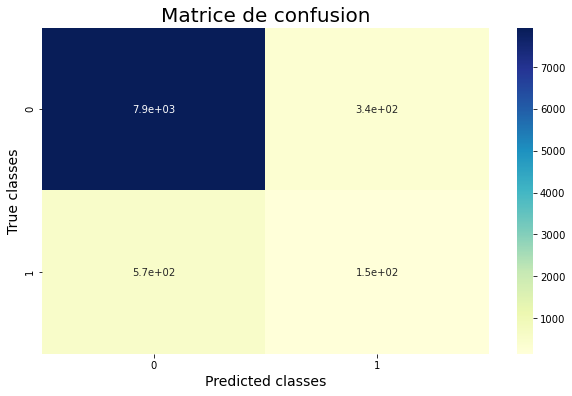

In [53]:
pred_test_ro_df = pd.DataFrame(index=X_test.index)
pred_test_ro_df['TARGET'] = y_test
pred_test_ro_df['predicted_class'] = clf_ro.predict(X_test[feats])
plt_confusion_matrix(pred_test_ro_df['TARGET'], pred_test_ro_df['predicted_class'])

Undersampling

In [38]:
from imblearn.under_sampling import RandomUnderSampler

rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_ru = np.zeros(X_ru.shape[0])
pred_test_ru = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_ru = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_ru = LGBMClassifier(
            colsample_bytree=0.9497036,
            #is_unbalance=True,
            feature_fraction=0.2,
            lambda_l1=3.26,
            lambda_l2=2.04,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=46.65184872316975,
            min_split_gain=0.008032569761590808,
            num_leaves=39,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            #scale_pos_weight=(282686 / 24825),
            silent=-1,
            subsample=0.8715623,
            verbose=-1, )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_ru.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train_ru[val_idx] = clf_ru.predict_proba(val_x,
                                                  num_iteration=clf_ru.best_iteration_)[:, 1]
    pred_test_ru += clf_ru.predict_proba(X_test[feats],
                                         num_iteration=clf_ru.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_ru = pd.DataFrame()
    fold_importance_df_ru["feature"] = feats
    fold_importance_df_ru["importance"] = clf_ru.feature_importances_
    fold_importance_df_ru["fold"] = n_fold + 1
    feature_importance_df_ru = pd.concat([feature_importance_df_ru, fold_importance_df_ru], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ru[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_ru, pred_train_ru))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[LightGBM] [Warning] lambda_l2 is set=2.04, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.04
Training until validation scores don't improve for 30 rounds
[100]	training's auc: 0.833314	training's binary_logloss: 0.562123	valid_1's auc: 0.732149	valid_1's binary_logloss: 0.617777
[200]	training's auc: 0.870441	training's binary_logloss: 0.507878	valid_1's auc: 0.736346	valid_1's binary_logloss: 0.607163
Early stopping, best iteration is:
[175]	training's auc: 0.861159	training's binary_logloss: 0.519362	valid_1's auc: 0.7381	valid_1's binary_logloss: 0.606852

 Fold  1 AUC : 0.738100
[LightGBM] [Warning] num_threads is

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78      1704
         1.0       0.77      0.78      0.78      1704

    accuracy                           0.78      3408
   macro avg       0.78      0.78      0.78      3408
weighted avg       0.78      0.78      0.78      3408



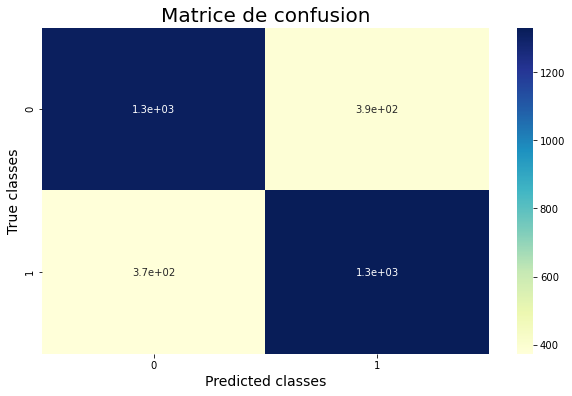

In [39]:
pred_train_ru_df = pd.DataFrame(index=X_ru.index)
pred_train_ru_df['predicted_class'] = clf_ru.predict(X_ru[feats])
pred_train_ru_df['TARGET'] = y_ru
plt_confusion_matrix(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80      8278
         1.0       0.16      0.70      0.27       722

    accuracy                           0.69      9000
   macro avg       0.56      0.70      0.53      9000
weighted avg       0.90      0.69      0.76      9000



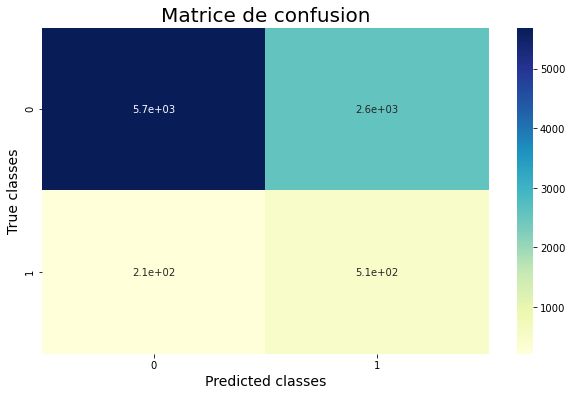

In [40]:
pred_test_ru_df = pd.DataFrame(index=X_test.index)
pred_test_ru_df['TARGET'] = y_test
pred_test_ru_df['predicted_class'] = clf_ru.predict(X_test[feats])
plt_confusion_matrix(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

In [41]:
def eval_metric_custom(y_true, y_pred):
    
    TP_value = 0
    # on prédit des difficultés et il y en a -> on a raison, pas d'impact
    
    FP_value = 0
    # on prévoit des difficultés mais il n'y en a pas -> pas d'impact pour la banque
    # le manque à gagner et comblé par le modèle, si on passe de FP à TN, on passe de 0 à 1
    
    TN_value = 1
    # On prévoit que tout se passe bien et c'est le cas -> meilleure configuration
    
    FN_value = -10
    # on prévoit que tout se passe bien et il y a des difficultés de paiement
    # -> à éviter au maximum
    
    score_final = 0 # on initialise le score à 0
        
    for proba in np.linspace(0.01,0.3,100):  # on teste le seuil de probabilité
        y_pred_proba = np.array(y_pred)
        
        for i in range(y_pred_proba.shape[0]):
        
            # convert probability to label with threshold 'proba'
            if y_pred_proba[i]<proba:
                y_pred_proba[i] = 0
            else:
                y_pred_proba[i] = 1
    
        conf_matrix = confusion_matrix(y_true, y_pred_proba)
        
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]
        tp = conf_matrix[1, 1]
    
        gain = tn*TN_value + fp*FP_value + fn*FN_value + tp*TP_value
    
        perfect_model = (tn + fp)*TN_value + (fn + tp)*TP_value
        # modèle parfait qui prédit les vraies classes
    
        no_model = (tn + fp)*TN_value + (tp + fn)*FN_value
        # modèle qui prédit toujours 0
    
        score = (gain - no_model) / (perfect_model - no_model)
        # on normalise le gain : score de 1 pour un modèle parfait 
        # et 0 pour un modèle qui dit toujours non
        
        if score > score_final:
            score_final = score
            threshold = proba
    
    print('seuil pour maximiser les profits :{}'.format(threshold))
    
    return 'score', score_final, True

In [42]:
eval_metric_custom(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

seuil pour maximiser les profits :0.01


('score', 0.7583920187793427, True)

In [43]:
eval_metric_custom(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

seuil pour maximiser les profits :0.01


('score', 0.34556786703601106, True)

In [38]:
eval_metric_custom(pred_test_ro_df['TARGET'], pred_test_ro_df['predicted_class'])

NameError: name 'pred_test_ro_df' is not defined

In [39]:
eval_metric_custom(pred_test_df['TARGET'], pred_test_df['predicted_class'])

NameError: name 'pred_test_df' is not defined

In [44]:
def feval_metric_custom(preds, train_data):
    
    y_true = train_data.get_label()
    y_pred = preds
    
    eval_name, eval_result, is_higher_better = eval_metric_custom(y_true, y_pred)
    
    return eval_name, eval_result, is_higher_better

In [45]:
df_class = df_class.drop(columns=zero_features)
train_df = df_class[feats]
train_target = df_class['TARGET']

In [46]:
df_class.to_csv('df_class.csv')

In [47]:
train_df.shape

(307507, 534)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_df,
                                                    train_target,
                                                    test_size=0.3, random_state=42)
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

In [49]:
# prepare data
ru_data = lgb.Dataset(data=X_ru, label=y_ru, free_raw_data=False)

# parameters
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':30,
              'learning_rate':0.03,
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, ru_data, nfold=5,
                       seed=6,verbose_eval =200,
                       feval=feval_metric_custom,
                       return_cvbooster=True)
    print(cv_result)
    return max(cv_result['score-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO_ru = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)

In [50]:
# optimize
lgbBO_ru.maximize(init_points=2, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.53905080314

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500018 -> initscore=0.000072
[LightGBM] [Info] Start training from score 0.000072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500018 -> initscore=0.000072
[LightGBM] [Info] Start training from score 0.000072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01

seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits

seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits

seuil pour maximiser les profits :0.11838383838383837
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.13595959595959595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.11838383838383837
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.14474747474747474
seuil pou

seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.12424242424242422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.12424242424242422
{'binary_logloss-mean': [0.6900714317182424, 0.6860553752395349, 0.6830000604402706, 0.6802017491727098, 0.6781753942332619, 0.6748125709887102, 0.6722357043540742, 0.6697067291311334, 0.6679318148274026, 0.6655401401668748, 0.6636812412514216, 0.6621445752094386, 0.6605075527159519, 0.6588152129670923, 0.6561793586311928, 0.6542256582886469, 0.6522239168747006, 0.6504690575440978, 0.6481841529750145, 0.6459923926543704, 0.6440860884804402, 0.6420121342540807, 0.6404718

[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] feature_fraction is set=0.8134184006256638, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8134184006256638
[LightGBM] [Info] Number of positive: 13906, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82335
[LightGBM] [Info] Number of data points in the train set: 27812, number of used features: 534
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, 

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil po

seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.25606060606060604
seuil pour 

seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.16818181818181818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.16818181818181818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.16818181

seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.09202020202020202
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1506060606060606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1418181818

seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.1301010101010101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.147676767676767

seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.12424242424242422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.12424242424242422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.11838383838383837
seuil pour maximiser l

seuil pour maximiser les profits :0.11252525252525251
seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1213131313131313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1213131313131313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.09787878787878787
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11545454545454543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.09787878787878787
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profit

seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.10959595959595958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.09494949494949494
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.10959595959595958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.09494949494949494
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.10959595959595958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
s

[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.5759468318620975, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.5759468318620975
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5390508031418598
[LightGBM] [Warning] lambda_l2 is set=2.1674963923113335, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1674963923113335
[LightGBM] [Warning] lambda_l1 is set=2.9699162251902895, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.9699162251902895
[LightGBM] [Warning] feature_fraction is set=0.894127419305972, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.894127419305972
[LightGBM] [Info] Number of positive: 13906, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise multi

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500018 -> initscore=0.000072
[LightGBM] [Info] Start training from score 0.000072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500018 -> initscore=0.000072
[LightGBM] [Info] Start training from score 0.000072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01

seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.25606060606060604
seuil pour maximiser les profits :0.27656565656565657
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profit

seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :

seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.16818181818181818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.16525252525252526
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.14767676767676768
seuil pour max

[LightGBM] [Warning] lambda_l2 is set=1.1076739957469837, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.1076739957469837
[LightGBM] [Warning] lambda_l1 is set=3.0317053220486354, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.0317053220486354
[LightGBM] [Warning] feature_fraction is set=0.5444570573181484, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.5444570573181484
[LightGBM] [Info] Number of positive: 13906, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82335
[LightGBM] [Info] Number of data points in the train set: 27812, number of used features: 534
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.57594683186209

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.000072
[LightGBM] [Info] Start training from score -0.000072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.2619191919191919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.23555555555555555
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.2677777777777778
seuil pour maximiser les profits :0.2619191919191919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

seuil pour maximiser les profits :0.24141414141414141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.26484848484848483
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.23848484848484847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.24727272727272726
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.24141414141414141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.22383838383838384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.21797979797979797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21212121212121213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.21212121212121213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.17696969696969697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.17696969696969697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1623232323232323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.1623232323232323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1213131313131313
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.14474747474747474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.17696969696969697
seuil pour maximiser le

seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.1388888888888889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.11252525252525251
seuil pour maximiser les profits :0.16818181818181818
seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.1388888888888889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

seuil pour maximiser les profits :0.1506060606060606
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.13595959595959595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.09787878787878787
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1623232323232323
seuil pour maximiser les profits :0.13595959595959595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Warning] lambda_l2 is set=1.3256213372319718, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.3256213372319718
[LightGBM] [Warning] lambda_l1 is set=2.987049058684822, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=2.987049058684822
[LightGBM] [Warning] feature_fraction is set=0.28912212603432275, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.28912212603432275
[LightGBM] [Info] Number of positive: 13906, number of negative: 13906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82335
[LightGBM] [Info] Number of data points in the train set: 27812, number of used features: 534
[LightGBM] [Warning] lambda_l2 is set=1.8082901282149315, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.8082901282149315
[LightGBM] [Warning] lambda_l1 is set=3.57594683186209

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour

seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.29414141414141415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.28828282828282825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

seuil pour maximiser les profits :0.2736363636363636
seuil pour maximiser les profits :0.2824242424242424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.27949494949494946
seuil pour maximiser les profits :0.2707070707070707
seuil pour maximiser les profits :0.2824242424242424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

seuil pour maximiser les profits :0.258989898989899
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.25606060606060604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.2619191919191919
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.25606060606060604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.23848484848484847
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.22969696969696968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.23262626262626263
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.22969696969696968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20919191919191918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.1798989898989899
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.2502020202020202
seuil pour maximiser les profits :0.20626262626262626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.2004040404040404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1388888888888889
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.19747474747474747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.1828282828282828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.1301010101010101
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.1798989898989899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.1711111111111111
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.1711111111111111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.12424242424242422
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.17404040404040405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.13595959595959595
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.16525252525252526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.11545454545454543
seuil pour maximiser les profits :0.13303030303030303
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.16525252525252526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.10959595959595958
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.15646464646464647
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.15646464646464647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10666666666666666
seuil pour maximiser les profits :0.12717171717171716
seuil pour maximiser les profits :0.15353535353535352
seuil pour maximiser les profits :0.17404040404040405
seuil pour maximiser les profits :0.15646464646464647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

seuil pour maximiser les profits :0.10373737373737373
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.14474747474747474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
seuil pour maximiser les profits :0.10080808080808079
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.1593939393939394
seuil pour maximiser les profits :0.14474747474747474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [51]:
lgbBO_ru.max

{'target': 0.9019674596799682,
 'params': {'feature_fraction': 0.8134184006256638,
  'lambda_l1': 4.818313802505147,
  'lambda_l2': 1.150324556477333,
  'max_depth': 8.166900152330658,
  'min_child_weight': 28.800271388880702,
  'min_split_gain': 0.0572364115482993,
  'num_leaves': 43.43752940414588}}

In [52]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_cm_final = np.zeros(X_ru.shape[0])
pred_test_cm_final = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_cm_final = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_cm_final = LGBMClassifier(
                colsample_bytree=0.9497036,
                feature_fraction=0.81,
                lambda_l1=4.818313802505147,
                lambda_l2=1.150324556477333,
                learning_rate=0.03,
                max_depth=8,
                min_child_weight=28.800271388880702,
                min_split_gain=0.0572364115482993,
                num_leaves=43,
                nthread=4,
                n_estimators=10000,
                objective='binary',
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                silent=-1,
                subsample=0.8715623,
                verbose=-1 )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_cm_final.fit(trn_x, trn_y,
                     eval_set=[(trn_x, trn_y), (val_x, val_y)],
                     eval_metric=eval_metric_custom,
                     verbose=100,
                     early_stopping_rounds=30
                     )

    pred_train_cm_final[val_idx] = clf_cm_final.predict_proba(val_x,
                                                              num_iteration=clf_cm_final.best_iteration_)[:,1] / folds.n_splits
    pred_test_cm_final += clf_cm_final.predict_proba(X_test[feats],
                                                     num_iteration=clf_cm_final.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_cm_final = pd.DataFrame()
    fold_importance_df_cm_final["feature"] = feats
    fold_importance_df_cm_final["importance"] = clf_cm_final.feature_importances_
    fold_importance_df_cm_final["fold"] = n_fold + 1
    feature_importance_df_cm_final = pd.concat([feature_importance_df_cm_final,
                                                fold_importance_df_cm_final], axis=0)


    eval_name, eval_result, is_higher_better = eval_metric_custom(val_y, pred_train_cm_final[val_idx])
    
    print('\n Fold %2d score : %.6f' %
              (n_fold + 1, eval_result))
    del trn_x, trn_y, val_x, val_y, eval_name, eval_result, is_higher_better

eval_name, eval_result, is_higher_better = eval_metric_custom(y_ru, pred_train_cm_final)
print('\n Full score %.6f' % eval_result)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
Training until validation scores don't improve for 30 rounds
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les pr

seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.20333333333333334
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.22676767676767676
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.19454545454545455
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.575991	training's score: 0.90197	valid_1's binary_logloss: 0.601371	v

seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.19454545454545455
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.1916161616161616
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22969696969696968
seuil pour maximiser les profits :0.18868686868686868
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.24434343434343433
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.18575757575757576
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits :0.1828282828282828
seuil pour maximiser les profits :0.24141414141414141
seuil pour maximiser les profits

seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profits :0.2004040404040404
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14474747474747474
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14767676767676768
seuil pour maximiser les profits :0.19747474747474747
seuil pour maximiser les profits :0.14181818181818182
seuil pour maximiser les profi

seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.22383838383838384
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.2209090909090909
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.21797979797979797
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.20919191919191918
seuil pour maximiser les profits :0.21505050505050505
seuil pour maximiser les profits :0.20626262626262626
seuil pour maximiser les profits :0.21212121212121213
seuil pour maximiser les profits

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.29414141414141415
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.2912121212121212
seuil pour maximiser les profits :0.29707070707070704
seuil pour maximiser les profits :0.28828282828282825
seuil pour maximiser les profits :0.28535353535353536
seuil pour maximiser les profits :0.2824242424242424
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.27363636363

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.3
seuil pour maximiser les profits :0.01
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.688308	training's score: 0.899993	valid_1's binary_logloss: 0.689031	valid_1's score: 0.900029
seuil pour maximiser les profits :0.01

 Fold  5 score : 0.900029
seuil pour maximiser les profits :0.030505050505050507

 Full score 0.900282


In [53]:
filename = 'LightGBMModel.pkl'
outfile = open(filename,'wb')
dump(clf_cm_final, outfile)
outfile.close()

              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68     17383
         1.0       0.69      0.64      0.66     17383

    accuracy                           0.67     34766
   macro avg       0.67      0.67      0.67     34766
weighted avg       0.67      0.67      0.67     34766



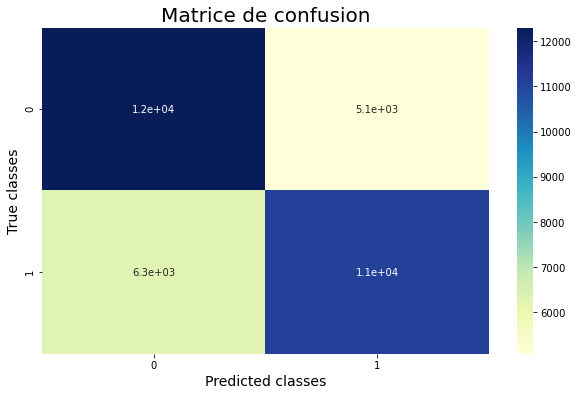

In [54]:
pred_train_cm_final_df = pd.DataFrame(index=X_ru.index)
pred_train_cm_final_df['predicted_class'] = clf_cm_final.predict(X_ru[feats])
pred_train_cm_final_df['TARGET'] = y_ru
plt_confusion_matrix(pred_train_cm_final_df['TARGET'], pred_train_cm_final_df['predicted_class'])

              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80     84811
         1.0       0.15      0.62      0.24      7442

    accuracy                           0.68     92253
   macro avg       0.55      0.65      0.52     92253
weighted avg       0.89      0.68      0.75     92253



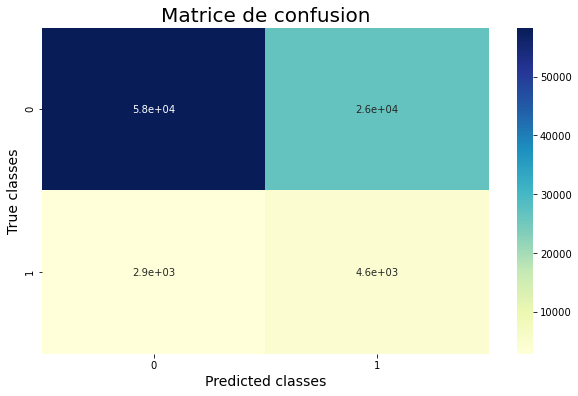

In [55]:
pred_test_cm_final_df = pd.DataFrame(index=X_test.index)
pred_test_cm_final_df['TARGET'] = y_test
pred_test_cm_final_df['predicted_class'] = clf_cm_final.predict(X_test[feats])
plt_confusion_matrix(pred_test_cm_final_df['TARGET'], pred_test_cm_final_df['predicted_class'])

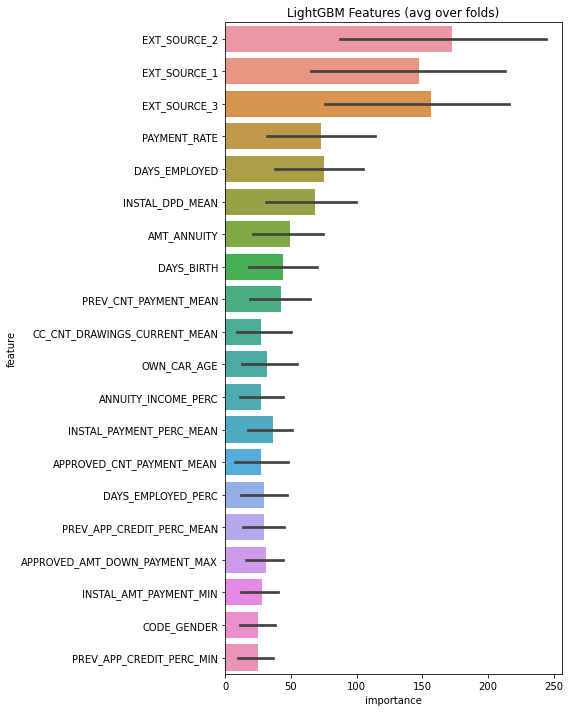

In [56]:
display_importances(feature_importance_df_ = feature_importance_df_cm_final)

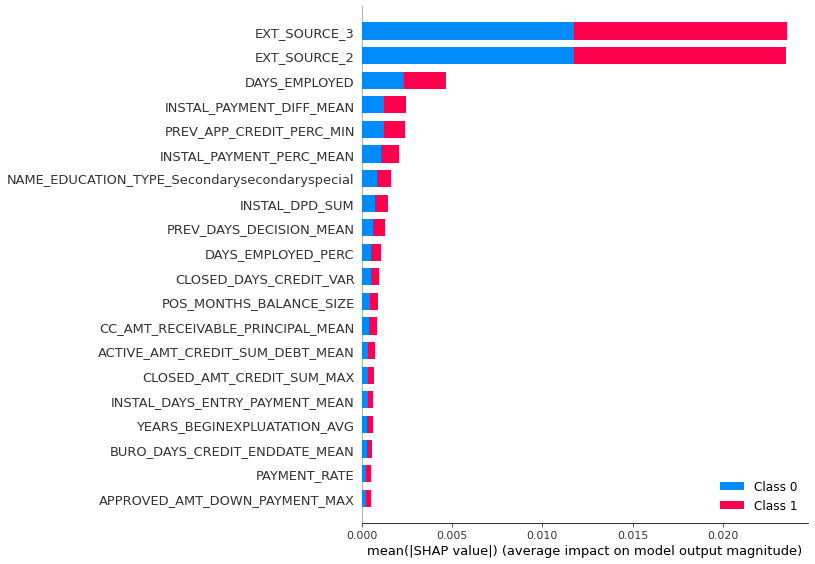

In [57]:
explainer = shap.TreeExplainer(clf_cm_final)
shap_values = explainer.shap_values(X_train[feats])

shap.summary_plot(shap_values, X_train[feats])


In [58]:
X_all = pd.concat([X_train[feats],X_test[feats]], axis=0)

In [59]:
from scipy.special import expit
# Conversion of shap values from log odds to probabilities
def shap_transform_scale(shap_values, expected_value, model_prediction):
    #Compute the transformed base value, which consists in applying the logit function to the base value
    expected_value_transformed = expit(expected_value)
    #Computing the original_explanation_distance to construct the distance_coefficient later on
    original_explanation_distance = sum(shap_values)
    #Computing the distance between the model_prediction and the transformed base_value
    distance_to_explain = model_prediction - expected_value_transformed
    #The distance_coefficient is the ratio between both distances which will be used later on
    distance_coefficient = original_explanation_distance / distance_to_explain
    #Transforming the original shapley values to the new scale
    shap_values_transformed = shap_values / distance_coefficient
    return shap_values_transformed, expected_value_transformed

In [ ]:
y_train.head()

In [60]:
explainer.expected_value[1]

-5.8444016570976956e-05

In [61]:
filename = 'expected_val.pkl'
outfile = open(filename,'wb')
dump(explainer.expected_value[1], outfile)
outfile.close()

In [62]:
model = clf_cm_final
model.fit(X_train[feats],y_train)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] lambda_l1 is set=4.818313802505147, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818313802505147
[LightGBM] [Warning] lambda_l2 is set=1.150324556477333, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.150324556477333


LGBMClassifier(colsample_bytree=0.9497036, feature_fraction=0.81,
               lambda_l1=4.818313802505147, lambda_l2=1.150324556477333,
               learning_rate=0.03, max_depth=8,
               min_child_weight=28.800271388880702,
               min_split_gain=0.0572364115482993, n_estimators=10000, nthread=4,
               num_leaves=43, objective='binary', reg_alpha=0.041545473,
               reg_lambda=0.0735294, silent=-1, subsample=0.8715623,
               verbose=-1)

In [63]:
explainer = shap.TreeExplainer(model)
shap_val_all = pd.DataFrame(explainer.shap_values(X_all)[1],
                           index = X_all.index,
                           columns=X_all.columns)
expected_value = explainer.expected_value[1]
shap_t, exp_t = shap_transform_scale(shap_val_all.iloc[-10],
                                    expected_value,
                                    model.predict_proba(X_all)[:,1][-10])
shap_val_all_trans = pd.Series(shap_t, index=X_all.columns)

In [65]:
filename = 'expected_val.pkl'
outfile = open(filename,'wb')
dump(explainer.expected_value[1], outfile)
outfile.close()

In [66]:
shap_val_all.to_csv('shap_val_all.csv')

In [54]:
model = clf_cm_final

X = X_train[feats]
explainer = shap.Explainer(model, X)
shap_values = explainer(X,check_additivity=False)

 98%|===================| 211887/215254 [00:21<00:00]        

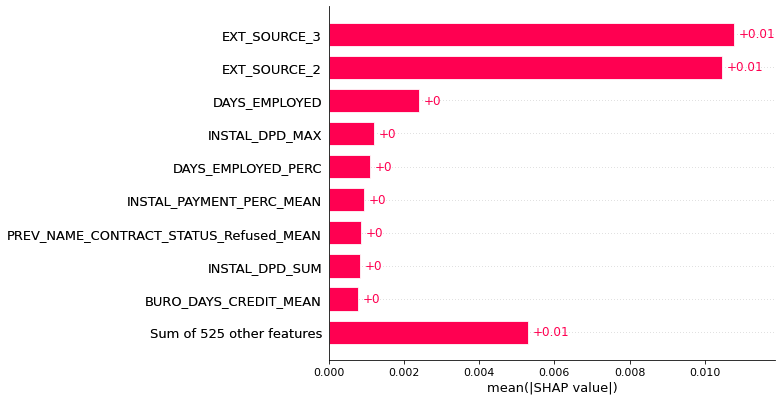

In [55]:
shap.plots.bar(shap_values)

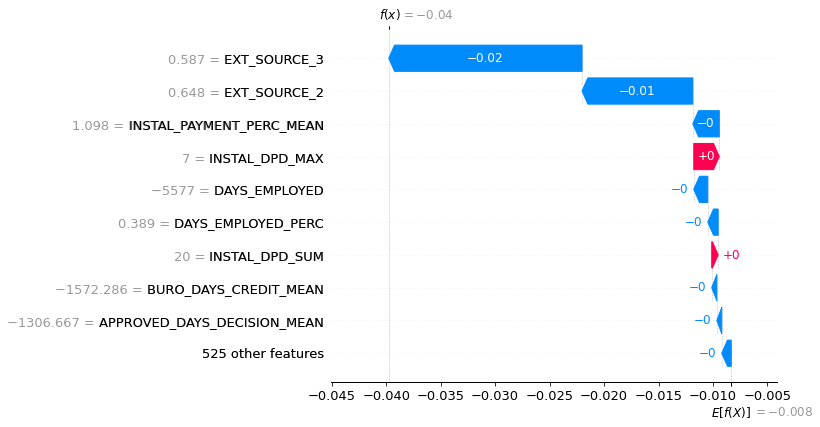

In [56]:
shap.plots.waterfall(shap_values[0])

In [57]:
feature_importance_df_cm_final.to_csv('feature_importance.csv')